## File info: 
- This file contains code for training the lightgbm model to forecast `total_visitor_count` for next day

In [1]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import pandas as pd
import lightgbm as lgb
import joblib
import seaborn as sns
import matplotlib.pyplot as plt


### buffer data
- create a historical buffer which contains total_visitor_count for each venue for past 6 days. This is useful to create lag features for the current day

In [2]:
forecasting_df = pd.read_csv('pre_processed_venue_data.csv')
file_destination = r'D:\Unacast\Unacast_challenge'
forecasting_df.drop(columns=['visitor_count_unique'], inplace=True)
forecasting_df['date'] = pd.to_datetime(forecasting_df['date'])
forecasting_df = forecasting_df[forecasting_df['date'] <= '2024-11-11']
forecasting_df[['date', 'venue_id', 'visitor_count_total']].groupby('venue_id').tail(6).to_csv(file_destination + '\historical_buffer.csv', header=True, index=False)

### Feature engineering

In [3]:
for i in range(1, 7):  # Assuming you want to calculate for lags 1 to 5
    # Calculate the lag for each venue_id
    forecasting_df[f'Lag_{i}'] = forecasting_df.groupby('venue_id')['visitor_count_total'].shift(i)

forecasting_df['Day_of_Week'] = forecasting_df['date'].dt.dayofweek
forecasting_df['day'] = forecasting_df['date'].dt.day
forecasting_df['Month'] = forecasting_df['date'].dt.month
forecasting_df['Year'] = forecasting_df['date'].dt.year
forecasting_df['venue_id'] = forecasting_df['venue_id'].astype('category')

print(forecasting_df.shape)


(225, 13)


### Train LGBMRegressor model 
- The aim is to find the best parameters using grid_serach and CV 

In [4]:
X, y = forecasting_df.drop(columns=['visitor_count_total', 'date']), forecasting_df['visitor_count_total']
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

cv_split = TimeSeriesSplit(n_splits=4, test_size=25)
model = lgb.LGBMRegressor(verbose=-1)
parameters = {
    "max_depth": [5, 10],
    "num_leaves": [10, 20],
    "learning_rate": [0.05, 0.1],
    "n_estimators": [50, 100],
    "colsample_bytree": [0.3, 0.5]
}

grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=25),
             estimator=LGBMRegressor(verbose=-1),
             param_grid={'colsample_bytree': [0.3, 0.5],
                         'learning_rate': [0.05, 0.1], 'max_depth': [5, 10],
                         'n_estimators': [50, 100], 'num_leaves': [10, 20]})

In [5]:
print(grid_search.best_params_)
# Predict
y_pred = grid_search.predict(X_test)
# Evaluate
mae = mean_absolute_error(y_test, y_pred)
print(f"mean absolute error on test data: {mae}")

{'colsample_bytree': 0.3, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 50, 'num_leaves': 10}
mean absolute error on test data: 60.167647205303204


### Final model
- use the best parameters obtained to train lightgbm model using training API. This allows model update at later stage

In [6]:
parameters = {'colsample_bytree': 0.3,
 'learning_rate': 0.05,
 'max_depth': 5,
 'n_estimators': 50,
 'num_leaves': 10}


train_data = lgb.Dataset(X_train, y_train)
lgb_trained = lgb.train(parameters, train_data, num_boost_round=100)

d:\TU Dortmund\Master thesis\Anomaly-Detection\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [7]:
# Predict with the updated model
y_pred = lgb_trained.predict(X_test)
# Evaluate the performance
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 60.167647205303204


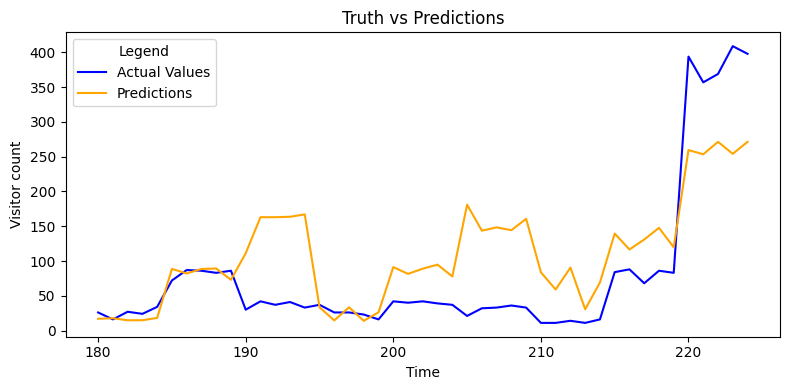

In [8]:
X_test['predictions'] = y_pred
X_test['truth'] = y_test

# create line plot
plt.figure(figsize=(8, 4))
sns.lineplot(data=X_test, x=X_test.index, y='truth', label='Actual Values', color='blue')
sns.lineplot(data=X_test, x=X_test.index, y='predictions', label='Predictions', color='orange')

# Add title, labels and legend
plt.title("Truth vs Predictions")
plt.xlabel("Time")
plt.ylabel("Visitor count")
plt.legend(title="Legend")


plt.tight_layout()
plt.show()


In [9]:
# Save the model
file_destination = r'D:\Unacast\Unacast_challenge'
lgb_trained.save_model(file_destination + '\Lightgbm_model\lightgbm_model.txt')
joblib.dump(lgb_trained, file_destination + '\Lightgbm_model\lightgbm_model.pkl')

['D:\\Unacast\\Unacast_challenge\\Lightgbm_model\\lightgbm_model.pkl']

In [ ]:
# loaded_model = lgb.Booster(model_file='lightgbm_model/lightgbm_model.txt')